# Lecture 23 - Part 2: Multi-Layer Perceptron (MLP), Backpropagation & Code Implementation

---

# Feed-forward Artificial Neural Network (ANN) or *Multi-Layer Perceptron (MLP)*

A **Multi-Layer Perceptron (MLP)** is a class of feed-forward artificial neural network (ANN). An MLP is composed of one **input layer**, one or more layers of TLUs, called **hidden layers**, and one final layer of TLUs called the **output layer**.  Except for the input nodes, each node is a neuron that uses an activation function (either linear or non-linear). 

* The layers close to the input layer are usually called the lower layers, and the ones close to the outputs are usually called the upper layers.
* Every layer except the output layer includes a bias neuron and is fully connected to the next layer.

Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable.

When an Artificial Neural Network (ANN) contains a deep stack of hidden layers, it is called a **deep neural network (DNN)**. The field of Deep Learning studies DNNs, and more generally models containing deep stacks of computations. 

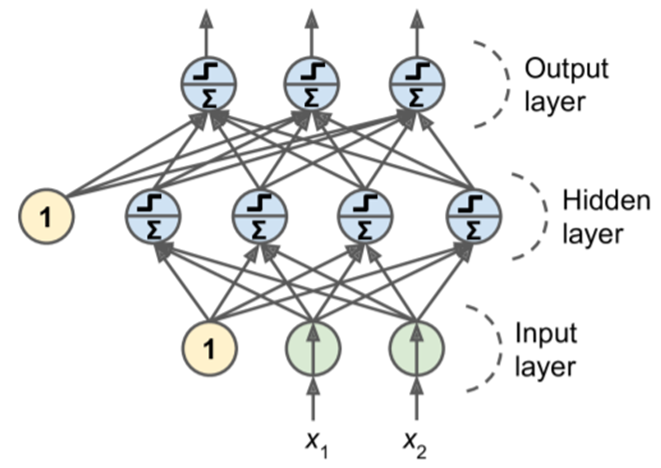

In [1]:
from IPython.display import Image
Image('figures/MLPs.png',width=400)
#Source: Aurélien Géron, "Hands-on machine learning with scikit-learn, keras and tensorflow"

In MLPs, each neuron's output can be subject to different activation functions. The choice of the activation function is in itself a *hyperparameter*.

* Which activation function would you use if you desired labels are $\{1,2,3,4,\dots,8,9\}$? 

* *What each of the layers do?*
    * The first hidden layer draws boundaries
    * The second hidden layer combines the boundaries
    * The third and further layers can generate arbitrarily complex shapes

___

## Types of Activation Functions

In artificial neural networks (ANN), the *activation function* of a neuron defines the output of that neuron given an input or set of inputs.

There are many activation functions, the most common are:

1. **Heaviside Step:**
\begin{align*}
\phi(x) = \begin{cases}1, & x >0 \\ 0, & x\leq 0\end{cases}
\end{align*}

2. **Linear:**
\begin{align*}
\phi(x) = x
\end{align*}

3. **Sigmoid:**
\begin{align*}
\phi(x) = \frac{1}{1+e^{-x}}
\end{align*}

4. **Hyperbolic Tangent (tanh):**
\begin{align*}
\phi(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
\end{align*}

5. **Rectified Linear Unit (ReLU):**
\begin{align*}
\phi(x) = \begin{cases} x, & x> 0 \\ 0, & x \leq 0\end{cases}
\end{align*}

6. **Leaky ReLu:**
\begin{align*}
\phi(x) = \begin{cases} x, & x> 0 \\ 0.01x, & x \leq 0\end{cases}
\end{align*}

7. **Exponential Linear Unit (ELU):**
\begin{align*}
\phi(x) = \begin{cases} x, & x> 0 \\ \alpha (e^x -1), & x \leq 0\end{cases}
\end{align*}

where $\alpha=1.67326$.

8. **Scaled Exponential Linear Unit (SELU):**
\begin{align*}
\phi(x) = \lambda\begin{cases} x, & x> 0 \\ \alpha (e^x -1), & x \leq 0\end{cases}
\end{align*}

where $\alpha=1.67326$ and $\lambda=1.0507$.

9. **Softplus:**
\begin{align*}
\phi(x) = \ln(1+e^x)
\end{align*}

There are many many [other functions](https://en.wikipedia.org/wiki/Activation_function) but these are the most popular.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [2]:
def activation_functions(x, alpha=1.67326, lam=1.0507):
    
    linear   = x
    sigmoid  = 1/(1+np.exp(-x))
    tanh     = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    softplus = np.log(1+np.exp(x))
    
    relu = x.copy()
    relu[x<=0] = 0
    
    leaky_relu = x.copy()
    leaky_relu[x<=0]=0.01*x[x<=0]
    
    elu = x.copy()
    elu[x<=0] = alpha*(np.exp(x[x<=0])-1)
    
    selu = 1.0507*x.copy()
    selu[x<=0] = lam*alpha*(np.exp(x[x<=0])-1)
        
    functions = np.vstack((linear, sigmoid, tanh, softplus, relu, leaky_relu, elu, selu)).T
    names = ['Linear', 'Sigmoid','Tanh','Softplus','ReLU','Leaky ReLU','ELU','SELU']
    
    return functions, names

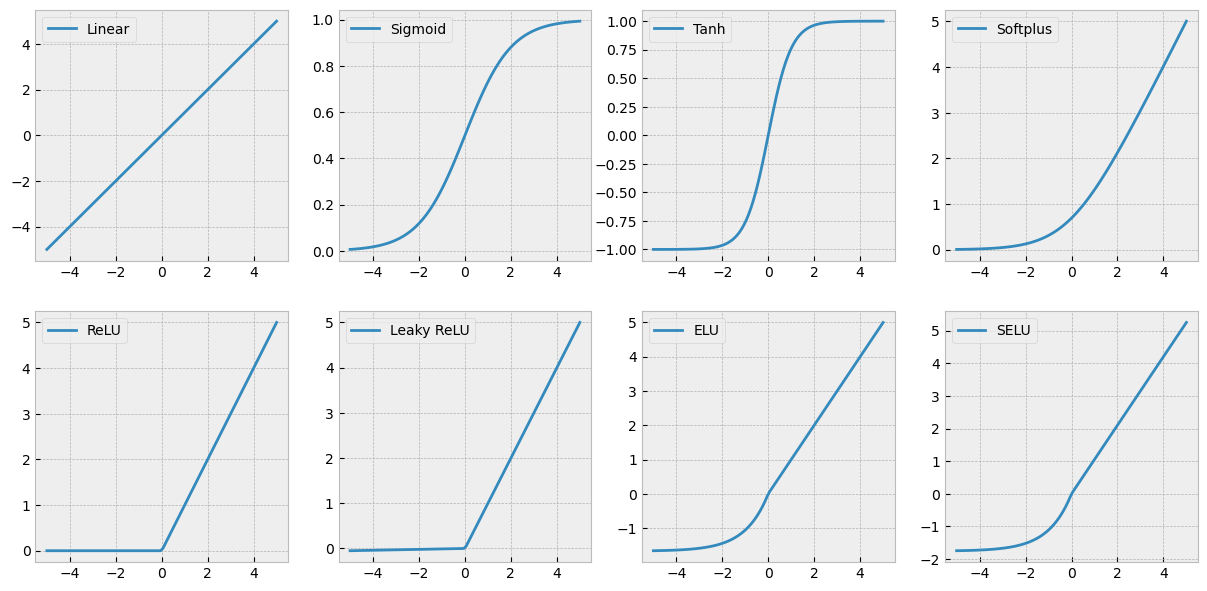

In [3]:
x = np.linspace(-5,5,100)
functions, names = activation_functions(x)

plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(4,4,i+1)
    plt.plot(x, functions[:,i], label=names[i])
    plt.legend();

---

# Regression and Classification MLPs

Since the Perceptron algorithm was published in 1957, many developments have been made in the design of complex networks. 

As mentioned above, an MLP is composed of one input layer, one or more layers of TLUs, called hidden layers, and one final layer of TLUs called the output layer. The layers close to the input layer are usually called the lower layers, and the ones close to the outputs are usually called the upper layers. Every layer except the output layer includes a bias neuron and is fully connected to the next layer.

The connections between neurons are called **weight connections**, or simply weights. And they represent the strength of connection. The larger the coefficient, in the absolute sense, the more importance that input neuron will have in the neuron it is connected to.

During training, our goal is to find the best values for the weights such the output predicts the desired target value. 

### Regression MLPs

MLPs can be used for regression tasks. 

* If you want to **predict a single value**, say, for example, the price of a house given many of its features, then you **just need a single output neuron**: its output is the predicted value. 

* For **multivariate regression**, say, to predict multiple values at once, you **need one output neuron per output dimension**. 

* Consider another example, to locate the center of an object on an image, you need to predict 2D coordinates, so you need two output neurons. If you also want to place a bounding box around the object, then you need two more numbers: the width and the height of the object. So, you end up with 4 output neurons.

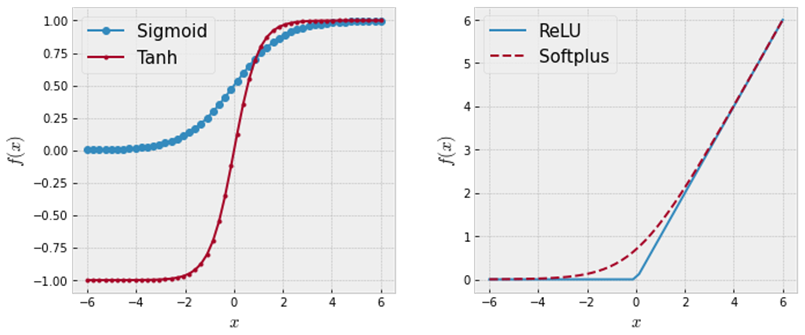

In [2]:
Image('figures/activation_functions.png',width=700)
#Source: Aurélien Géron, "Hands-on machine learning with scikit-learn, keras and tensorflow"

In general, when building an MLP for regression, you do not want to use any **activation function** for the output neurons, so they are free to output any range of values. 

However, if you want to guarantee that the output will always be positive, then you can use the **ReLU activation function**, or the **softplus activation function** in the output layer. 

Finally, if you want to guarantee that the predictions will fall within a given range of values, then you can use the **sigmoid** function or the **hyperbolic tangent** and scale the labels to the appropriate range: 0 to 1 for the logistic function, or –1 to 1 for the hyperbolic tangent.

The loss function to use during training is typically the mean squared error, but if you have a lot of outliers in the training set, you may prefer to use the mean absolute error instead. Alternatively, you can use the Huber loss, which is a combination of both.

### Hyperparameter for Regression MLPs

The hyperparameters represent the set of controllable factors during the design of the MLP architecture. Here is an example of the hyperparameter choices for training an MLP for a regression task.

|Hyperparameter| Typical Value|
| --| --| 
| # input neurons  | One per input feature (e.g., 28x28 =784 for MNIST)  |
|  # hidden layer |  Depends on the problem. Typically, 1 to 5. |
|  # neurons per hidden layer |  Depends on the problem. Typically, 10 to 100. |
| # output neurons  |  1 per prediction dimension |
|  Hidden activation function |  ReLU |
|  Output activation function |  None or ReLU/Softplus (if positive outputs) or Logistic/Tanh (if bounded outputs) |
| Loss function  |  MSE or MAE/Huber (if outliers) |

### Classification MLPs

MLPs, and artificial neural networks in general, can perform both regression and classification tasks.

For a **binary classification problem**, you just need a **single output neuron using the sigmoid activation function**: the output will be a number between 0 and 1, which you can interpret as the estimated probability of the positive class. Obviously, the estimated probability of the negative class is equal to one minus that number.

MLPs can also easily handle **multilabel binary classification tasks**. For example, you could have an email classification system that predicts whether each incoming email is non-spam or spam, and simultaneously predicts whether it is an urgent or non-urgent email. In this case, you would need two output neurons, both using the sigmoid activation function: the first would output the probability that the email is spam and the second would output the probability that it is urgent. More generally, you would dedicate one output neuron for each positive class. Note that the output probabilities do not necessarily add up to one. This lets the model output any combination of labels: you can have non-urgent ham, urgent ham, non-urgent spam, and perhaps even urgent spam (although that would probably be an error).

If each instance can belong only to a single class, out of 3 or more possible classes (for example, classes 0 through 9 for digit image classification), then you need to have one output neuron per class, and you should use the softmax activation function for the whole output layer. The softmax function will ensure that all the estimated probabilities are between 0 and 1 and that they add up to one (which is required if the classes are exclusive). This is called multiclass classification. 

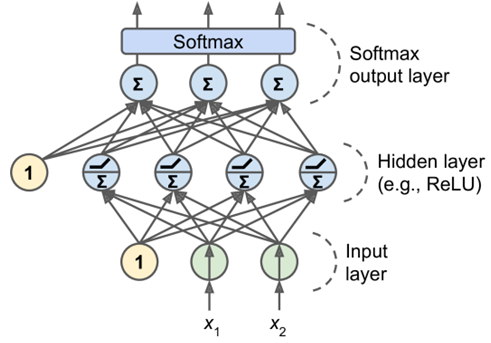

In [3]:
Image('figures/classification_MLPs.png',width=400)
#Source: Aurélien Géron, "Hands-on machine learning with scikit-learn, keras and tensorflow"

| Hyperparameter | Binary Classification | Multilabel binary classification | Multiclass classification|
| --| --| --| --|
| Input and hidden layers | Same as regression | Same as regression | Same as regression|
| # output neurons | 1 | 1 per label | 1 per class|
|Output layer activation | Sigmoid | Sigmoid | Softmax |
| Loss function | Cross-Entropy | Cross-Entropy | Cross-Entropy |

---

# Universal Approximation Theorem

"The *Universal Approximation Theorem* states that a feed-forward network with a single hidden layer containing a finite number of neurons can approximate continuous functions on compact subsets of $\mathbb{R}^N$, under mild assumptions on the activation function. The theorem thus states that simple neural networks can represent a wide variety of interesting functions when given appropriate parameters; however, it does not touch upon the algorithmic learnability of those parameters."

Let $\phi(\cdot)$ be a non-constant, bounded and monotonic-increasing continuous function. Let $I_{m_0}$ denote the $m_0$-dimensional unit hypercube $[0, 1]^{m_0}$. The space of continuous functions on $I_{m_0}$ is denoted by $C(I_{m_0})$.  Then, given any function $f \ni C(I_{m_0})$ and $\epsilon > 0$, there exists an integer $m_1$ and sets of real constants $\alpha_i, \beta_i,$ and $w_{ij}$, where $i = 1, \ldots, m_1$ and $j = 1, \ldots, m_0$ such that we may define

\begin{align*}
F(x_1, \ldots, x_{m_0}) = \sum_{i=1}^{m_1} \alpha_i \phi\left( \sum_{j=1}^{m_0} w_{ij}x_j + b_i\right)
\end{align*}

as an approximation realization of the function $f(\cdot)$, that is, 

\begin{align*}
\left| F(x_1, \ldots, x_{m_0}) - f(x_1, \ldots, x_{m_0}) \right| < \epsilon
\end{align*}

for all $x_1, x_2, \ldots, x_{m_0}$ that like in the input space.

Essentially, the Universal Approximation Theorem states that a single hidden layer is sufficient for a multilayer perceptron to compute a uniform $\epsilon$ approximation to a given training set - provided you have the *right* number of neurons and the *right* activation function. 

* However, this does not say that a single hidden layer is optimal with regards to learning time, generalization, etc.)

* In other words, a **feed-forward MLP with one hidden layer can approximate arbitrarily closely any continuous function**. (Wow!)

___

# Exercise 1

Suppose you had the following neural network:

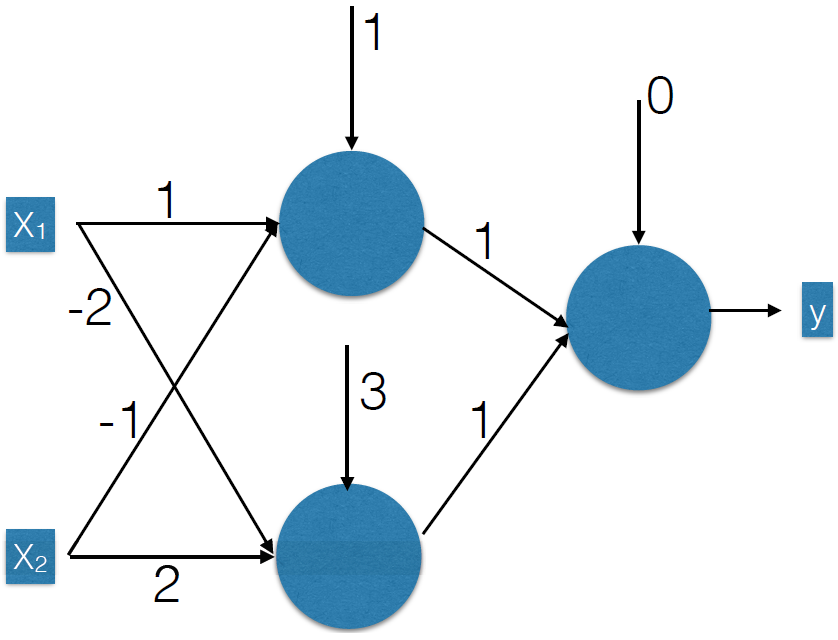

In [4]:
Image('figures/MLP-exercise.png', width=300)

with the activation function:

\begin{align*}
\phi(x) = \begin{cases} 1 & x > 0 \\ -1 & x \leq 0 \end{cases}
\end{align*}

1. What is the expression of the output value $y$ in terms of the input values?

2. What is the output with the following input values?
    * $[0,0]$
    * $[-2, -2.5]$
    * $[-5, 5]$
    * $[10, 3]$

3. What does the decision surface of this network look like graphically? Draw it out by hand.

---

# Decision Maps in MLPs

[A Neural Network Playground](https://playground.tensorflow.org/#activation=tanh&regularization=L2&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.1&regularizationRate=0&noise=10&networkShape=2&seed=0.66302&showTestData=false&discretize=false&percTrainData=80&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) is a great tool to provide visual interpretation of MLPs performance. You can choose and interpret the effect of the use of different features, architecture size, learning rate, among others.

---

# Backpropagation

* The learning procedure involves the presentation of a set of pairs of input and output patterns, $X=\{x_i\}_{i=1}^N$ and $Y=\{y_j\}_{j=1}^M$. The system uses the input vector to produce its own output vector and then compares this with the *desire output*, or *target output* $t=\{t_j\}_{j=1}^M$. If there is no difference, no learning takes place. Otherwise, the weights are changed to reduce the difference. This procedure is basically the perceptron learning algorithm.

* This procedure can be *automated* by the machine itself, without any outside help, if we provide some **feedback** to the machine on how it is doing. The feedback comes in the form of the definition of an *error criterion* or *objective function* that must be *minimized* (e.g. Mean Squared Error). For each training pattern we can define an error ($\epsilon_k$) between the desired response ($t_k$) and the actual output ($y_k$). Note that when the error is zero, the machine output is equal to the desired response. This learning mechanism is called **(error) backpropagation** (or **BP**).

* The backpropagation algorithm consists of two phases: 
     * **Forward phase:** computes the *functional signal*, feed-forward propagation of input pattern signals through the network.
    * **Backward phase:** computes the *error signal*, propagates the error backwards through the network starting at the output units (where the error is the difference between desired and predicted output values).

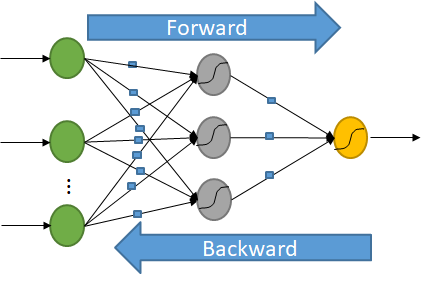

In [5]:
Image('figures/ForwardBackward.png',width=400)

* **Objective function/Error Criterion:** there are many possible definitions of the error, but commonly in neuro-computing one uses the error variance (or power):

\begin{align*}
J(w) = \frac{1}{2}\sum_{k=1}^N e_k^2 = \frac{1}{2} \sum_{k=1}^N (t_k-y_k)^2 = \frac{1}{2} \sum_{k=1}^N (t_k-w^Tx_k)^2
\end{align*}

* Now we need to define an **adaptive learning** algorithm. Backpropagation commonly uses the gradient descent as the adaptive learning algorithm.

* **Adaptive Learning Algorithm:** there are many learning algorithms, the most common is the method of Gradient/Steepest Descent.
    * Move in direction opposite to the gradient, $\nabla J(\mathbf{w})$, vector (**gradient descent**):

\begin{align*}
w^{(n+1)} &= w^{(n)} + \Delta w^{(n)}
\end{align*}

This is known as the **error correction rule**. We define: 

\begin{align*}
\Delta w^{(n)} &= w^{(n)} - w^{(n-1)}\\
\Delta w^{(n)} &= - \eta \nabla J(w^{(n)})
\end{align*}

where $\eta$ is the learning rate.

## Backpropagation of the Error for the Output Layer

There are many approaches to train a neural network. One of the most commonly used is the **Error Backpropagation Algorithm**. 

Let's first consider the output layer:
* Given a training set, $\left\{ (x_n, t_n)\right\}_{n = 1}^N$, we want to find the parameters of our network that minimizes the squared error: 

\begin{align*}
J(w) = \frac{1}{2} \sum_{l=1}^N (t_l - y_l)^2
\end{align*}

* In order to use gradient descent, we need to compute the analytic form of the gradient, $\frac{\partial J}{\partial w_{lj}}$.

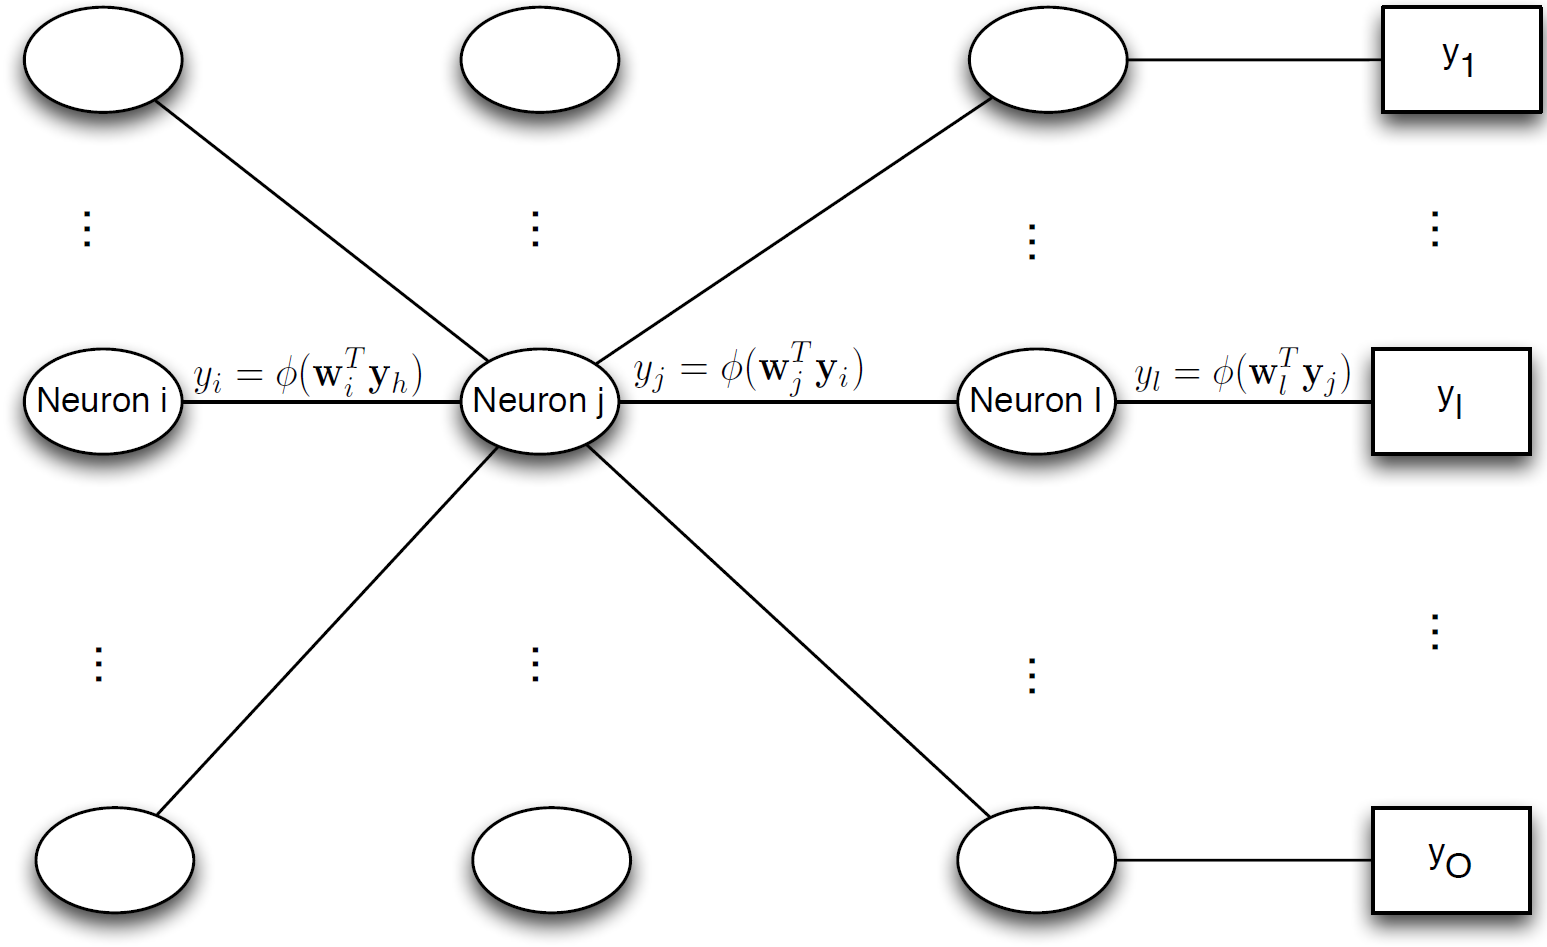

In [6]:
Image('figures/HiddenLayer.png',width=700)

<div class="alert alert-info">
    <b>Chain Rule</b>

Given a labelled training set, $\left\{ x_n, d_n\right\}_{n = 1}^N$, consider the objetive function 

\begin{align*}
J(w) = \frac{1}{2} \sum_{l=1}^N e_l^2
\end{align*}

where $w$ are the parameters to be estimated and $\forall l$: 

\begin{align*}
e_l &= t_l - y_l \\
y_l &= \phi(v_l)\text{, }\phi(\bullet)\text{ is an activation function}\\
v_l &= w^Tx_j\text{ (note that }x_j\in\mathbb{R}^{D+1}\text{)}  
\end{align*}

Using the Chain Rule, we find:

\begin{align*}
\frac{\partial J}{\partial w_{lj}} = \frac{\partial J}{\partial e_l} \frac{\partial e_l}{\partial y_l} \frac{\partial y_l}{\partial v_l} \frac{\partial v_l}{\partial w_{lj}}
\end{align*}

where
\begin{align*}
\frac{\partial J}{\partial e_l} = \frac{1}{2} 2 e_l = e_l = t_l - y_l
\end{align*}

\begin{align*}
\frac{\partial e_l}{\partial y_l} = -1
\end{align*}

\begin{align*}
\frac{\partial y_l}{\partial v_l} = \frac{\partial \phi(v_l)}{\partial v_l} = \phi'(v_l)
\end{align*}

\begin{align*}
\frac{\partial v_l}{\partial w_{lj}} = x_j
\end{align*}

Therefore

\begin{align*}
\frac{\partial J}{\partial w_{lj}} = e_l (-1) \phi'(v_l) x_j
\end{align*}

</div>

Now that we have the gradient, how do we use this to update the output layer weights in our MLP?

\begin{align*}
w_{lj}^{(t+1)} = w_{lj}^{(t)} - \eta \frac{\partial J}{\partial w_{lj}} = w_{lj}^{(t)} + \eta e_i\phi'(v_l) x_j
\end{align*}

* How will this update equation  (for the output layer) change if the network is a multilayer perceptron with hidden units?

* Can you write this in vector form to update all weights simultaneously?

* Next, the hidden layers...

---

## Popular Activation Functions and Their Derivatives

| Activation function | $\phi(x)$ | $\phi'(x) = \frac{d\phi(x)}{dx}$ |
| -- | -- | -- |
| Linear | $x$ | $1$ |
| Sigmoid/Logistic | $\frac{1}{1+e^{-x}}$ | $\phi(x)(1-\phi(x))$ |
| Tanh | $\frac{e^{x}-e^{-x}}{e^x + e^{-x}}$ | $1-\phi(x)^2$ |
| ReLU | $\begin{cases}0, & x \leq 0 \\ x, & x>0 \end{cases}$ | $\begin{cases}0, & x < 0 \\ 1, & x>0 \\ \text{undefined}, & x=0\end{cases}$ |
| Leaky ReLU | $\begin{cases}0.01 x, & x \leq 0 \\ x, & x>0 \end{cases}$ | $\begin{cases}0.01, & x < 0 \\ 1, & x>0 \\ \text{undefined}, & x=0\end{cases}$ |
| Softplus | $(1+e^x)$ | $\frac{1}{1+e^{-x}}$ |
| ELU | $\begin{cases}\alpha(e^x-1), & x \leq 0 \\ x, & x>0 \end{cases}$ |  $\begin{cases}\alpha e^x, & x < 0 \\ 1, & x>0 \\ 1, & x>0 \text{ and } \alpha=1  \end{cases}$ |
| SELU | $\lambda\begin{cases}\alpha(e^x-1), & x < 0 \\ x, & x\geq 0 \end{cases}$ | $\lambda\begin{cases}\alpha e^x, & x < 0 \\ 1, & x\geq 0 \end{cases}$ |

---

## Backpropagation of the Error for the Hidden Layers

* In a neural network, we can only define an error at the output layer! Therefore, we need to backward propagate the error obtain at the output layer, hence *backpropagation*.

Suppose we want to update $w_{ji}$ where $j$ is the hidden layer. (Let's follow the labeling in the figure below.)

The error objective function overall $N$ data points is 

\begin{align*}
J(w) = \frac{1}{2} \sum_{l=1}^N e_l^2 = \frac{1}{2} \sum_{l=1}^N \left(d_l - y_l\right)^2 = \frac{1}{2} \sum_{l=1}^N \left(d_l - \phi_l(v_l)\right)^2
\end{align*}

As we have seen earlier,

\begin{align*}
\frac{\partial J}{\partial w_{lj}} &= \frac{\partial J}{\partial e_l} \frac{\partial e_l}{\partial y_l} \frac{\partial y_l}{\partial v_l} \frac{\partial v_l}{\partial w_{lj}} \\
&= e_l (-1) \phi'(v_l) y_{jl}
\end{align*}

Let's define the *local gradient* $\delta_l$:

\begin{align*}
\delta_l &= -\frac{\partial J}{\partial v_l} \\
&= e_l \phi'(v_l)
\end{align*}

Similarly,

\begin{align*}
\delta_j &= -\frac{\partial J}{\partial v_j} \\
&= -\frac{\partial J}{\partial y_j} \frac{\partial y_j}{\partial v_j} \\
&= -\frac{\partial J}{\partial y_j} \phi'(v_j)
\end{align*}

Note that,

\begin{align*}
\frac{\partial J}{\partial y_j} &= \sum_l \frac{\partial J}{\partial e_l} \frac{\partial e_l}{\partial y_l} \frac{\partial y_l}{\partial v_l} \frac{\partial v_l}{\partial y_j} \\
&= \sum_l e_l (-1) \phi'(v_l) w_{lj} \\
\end{align*}

So,

\begin{align*}
\delta_j &= -\frac{\partial J}{\partial y_j} \phi'(v_j) \\
&= - \left[ \sum_l e_l (-1) \phi'(v_l) w_{lj} \right] \phi'(v_j) \\
&= \phi'(v_j)\sum_l \delta_l w_{lj}
\end{align*}

* We can write the gradient at a hidden neuron in terms of the local gradient and the connect neurons in the next layer:

\begin{align*}
\Delta w_{ij} = \eta \delta_j x_i
\end{align*}

And so,

\begin{align*}
w_{ij}^{t+1} \leftarrow w_{ij}^{t} + \Delta w_{ij}^{t}
\end{align*}

---

# Universal Approximation Theorem

"The *Universal Approximation Theorem* states that a feed-forward network with a single hidden layer containing a finite number of neurons can approximate continuous functions on compact subsets of $\mathbb{R}^N$, under mild assumptions on the activation function. The theorem thus states that simple neural networks can represent a wide variety of interesting functions when given appropriate parameters; however, it does not touch upon the algorithmic learnability of those parameters."

Let $\phi(\cdot)$ be a non-constant, bounded and monotonic-increasing continuous function. Let $I_{m_0}$ denote the $m_0$-dimensional unit hypercube $[0, 1]^{m_0}$. The space of continuous functions on $I_{m_0}$ is denoted by $C(I_{m_0})$.  Then, given any function $f \ni C(I_{m_0})$ and $\epsilon > 0$, there exists an integer $m_1$ and sets of real constants $\alpha_i, \beta_i,$ and $w_{ij}$, where $i = 1, \ldots, m_1$ and $j = 1, \ldots, m_0$ such that we may define

\begin{align*}
F(x_1, \ldots, x_{m_0}) = \sum_{i=1}^{m_1} \alpha_i \phi\left( \sum_{j=1}^{m_0} w_{ij}x_j + b_i\right)
\end{align*}

as an approximation realization of the function $f(\cdot)$, that is, 

\begin{align*}
\left| F(x_1, \ldots, x_{m_0}) - f(x_1, \ldots, x_{m_0}) \right| < \epsilon
\end{align*}

for all $x_1, x_2, \ldots, x_{m_0}$ that like in the input space.

Essentially, the Universal Approximation Theorem states that a single hidden layer is sufficient for a multilayer perceptron to compute a uniform $\epsilon$ approximation to a given training set - provided you have the *right* number of neurons and the *right* activation function. 

* However, this does not say that a single hidden layer is optimal with regards to learning time, generalization, etc.)

* In other words, a **feed-forward MLP with one hidden layer can approximate arbitrarily closely any continuous function**. (Wow!)

___

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# Helper function
def plot_LC_and_DB(X, model):
    '''This function will plot the learning curve and decision boundary
    for a given trained model and training data X.
    model: is a sklearn model structure
    X: training data'''
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
    
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(1,2,1)
    plt.plot(model.loss_curve_)
    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Function')

    cm = ListedColormap(['blue', 'orange'])
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape) 
    fig.add_subplot(1,2,2)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.8);
    plt.title('Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show();

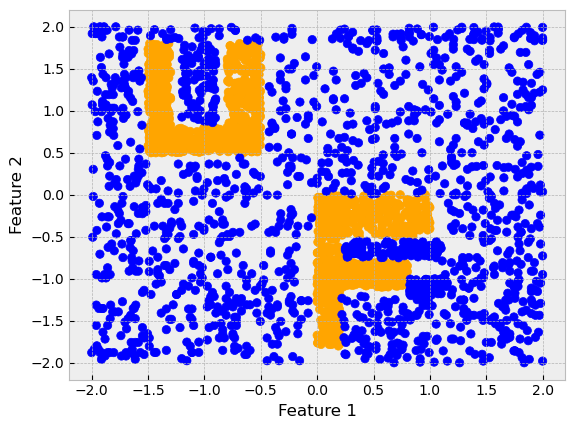

In [5]:
from matplotlib.colors import ListedColormap

UF_network = np.load('UF_network.npy')
X = UF_network[:,:2]
t = UF_network[:,2]

cm = ListedColormap(['blue', 'orange'])
plt.scatter(X[:,0],X[:,1],c=t, cmap=cm);
plt.xlabel('Feature 1')
plt.ylabel('Feature 2');

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

# Do not change these parameters
net = MLPClassifier(activation='tanh',
                    n_iter_no_change = 1000,
                    tol=0.1)

/Users/catiaspsilva/anaconda3/envs/fml/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


-----------------------------------
Hidden Layer Architecture:  (30,)
Learning Rate:  0.01
Number of Epochs:  1000
Accuracy =  99.43 %
-----------------------------------


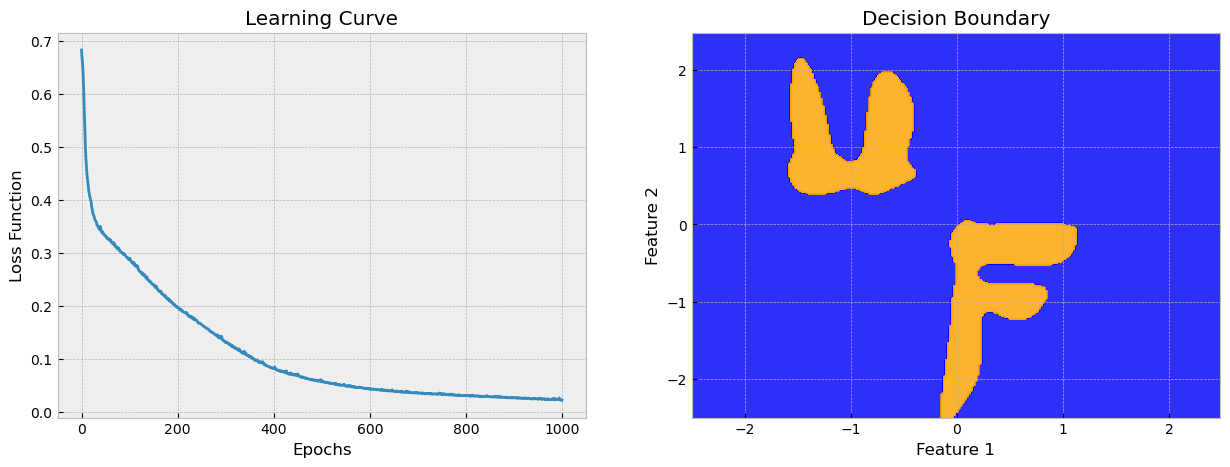

-----------------------------------
Hidden Layer Architecture:  (16, 6)
Learning Rate:  0.01
Number of Epochs:  1000
Accuracy =  99.77 %
-----------------------------------


/Users/catiaspsilva/anaconda3/envs/fml/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


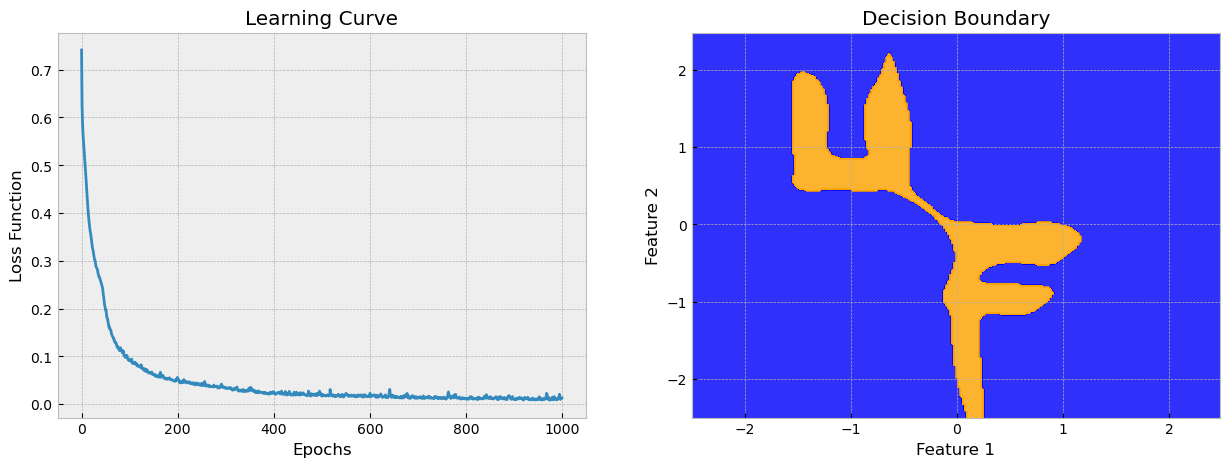

In [7]:
# Create a list with your own set of values for all of these parameters
net_hidden_layers = [(30,), (16,6)]
net_learning_rate = [0.01]
epochs = [1000]

for i in net_hidden_layers:
    for j in net_learning_rate:
        for k in epochs:
            net.set_params(hidden_layer_sizes = i, learning_rate_init = j, max_iter = k)
            net.fit(X, t)
            t_pred = net.predict(X)
            acc_score = accuracy_score(t, t_pred)
            print('-----------------------------------')
            print('Hidden Layer Architecture: ', i)
            print('Learning Rate: ', j)
            print('Number of Epochs: ', k)
            print('Accuracy = ', np.round(acc_score*100,2),'%')
            print('-----------------------------------')
            plot_LC_and_DB(X, net)

In [8]:
net.coefs_[0].shape, net.coefs_[1].shape, net.coefs_[2].shape

((2, 16), (16, 6), (6, 1))

In [9]:
net.intercepts_[0].shape, net.intercepts_[1].shape, net.intercepts_[2].shape

((16,), (6,), (1,))

In [10]:
tanh = lambda x: (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

In [11]:
h1 = tanh(X@net.coefs_[0] + net.intercepts_[0])

h1.shape

(3000, 16)

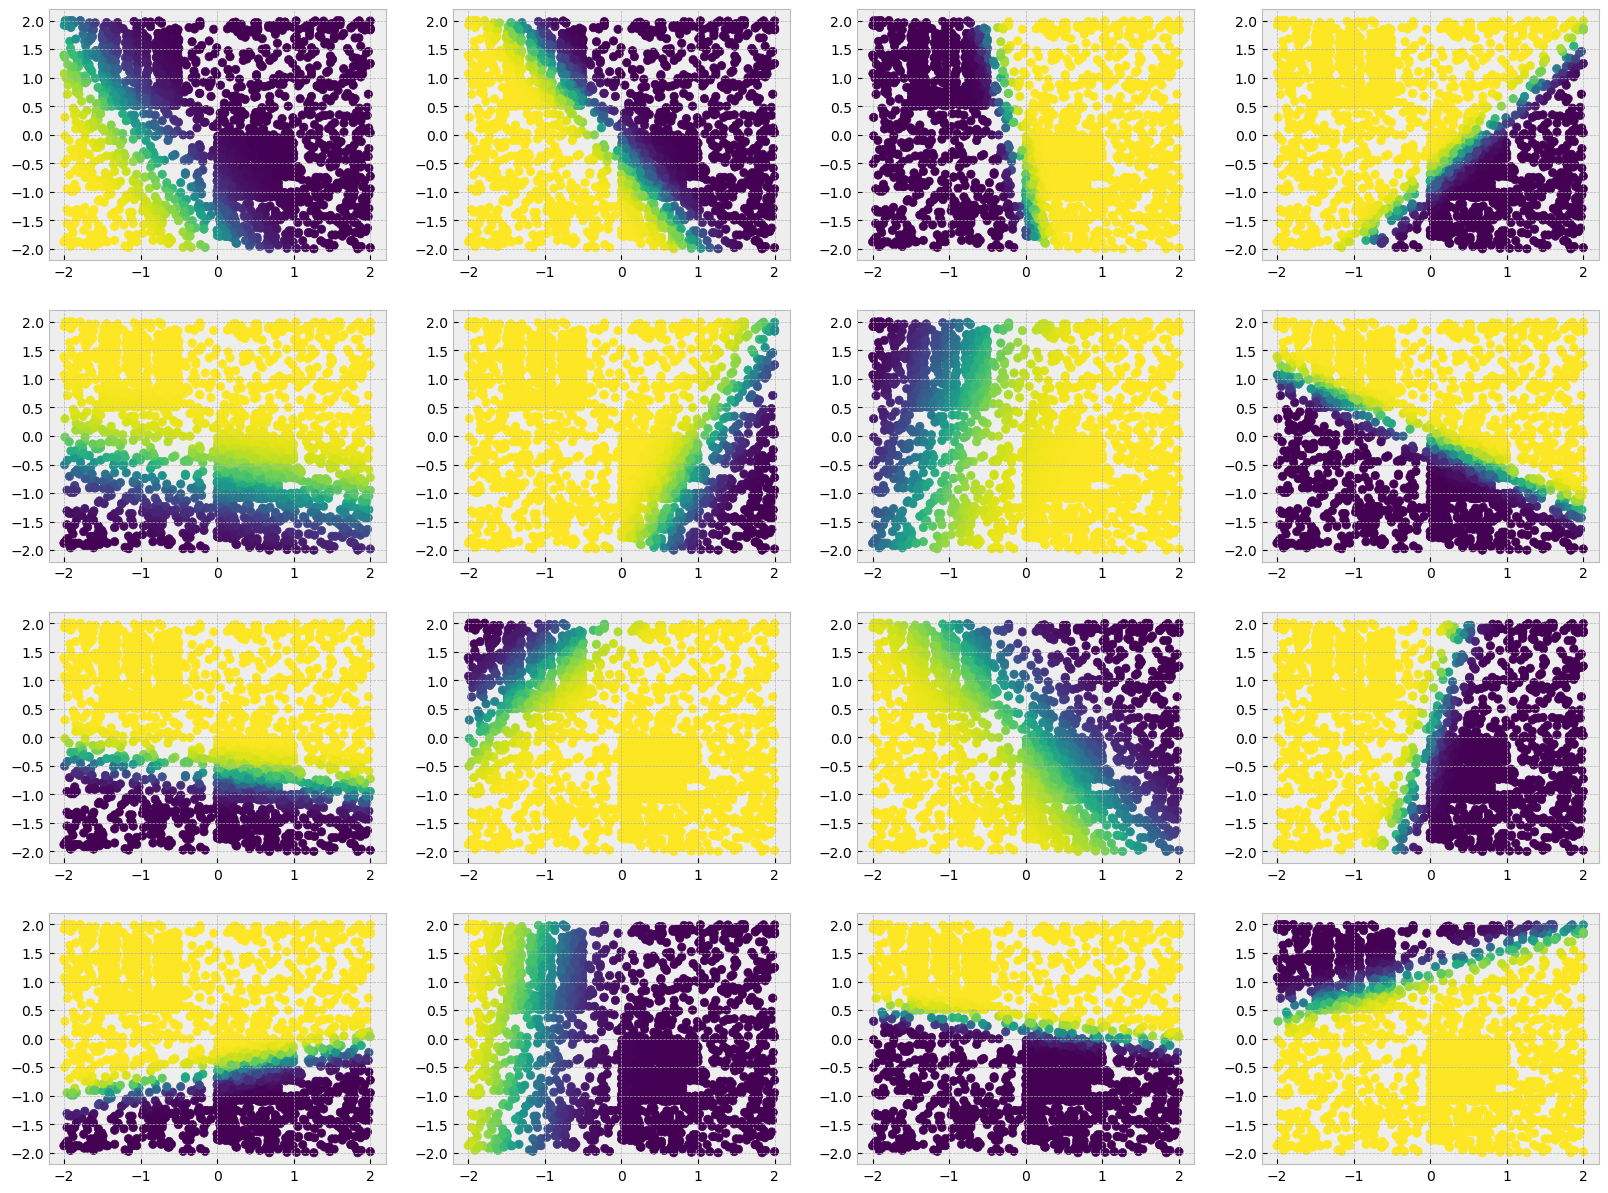

In [12]:
plt.figure(figsize=(20,15))
for i in range(h1.shape[1]):
    plt.subplot(4,4,i+1)
    plt.scatter(X[:,0], X[:,1], c=h1[:,i]);

In [13]:
h2 = tanh(h1@net.coefs_[1] + net.intercepts_[1])

h2.shape

(3000, 6)

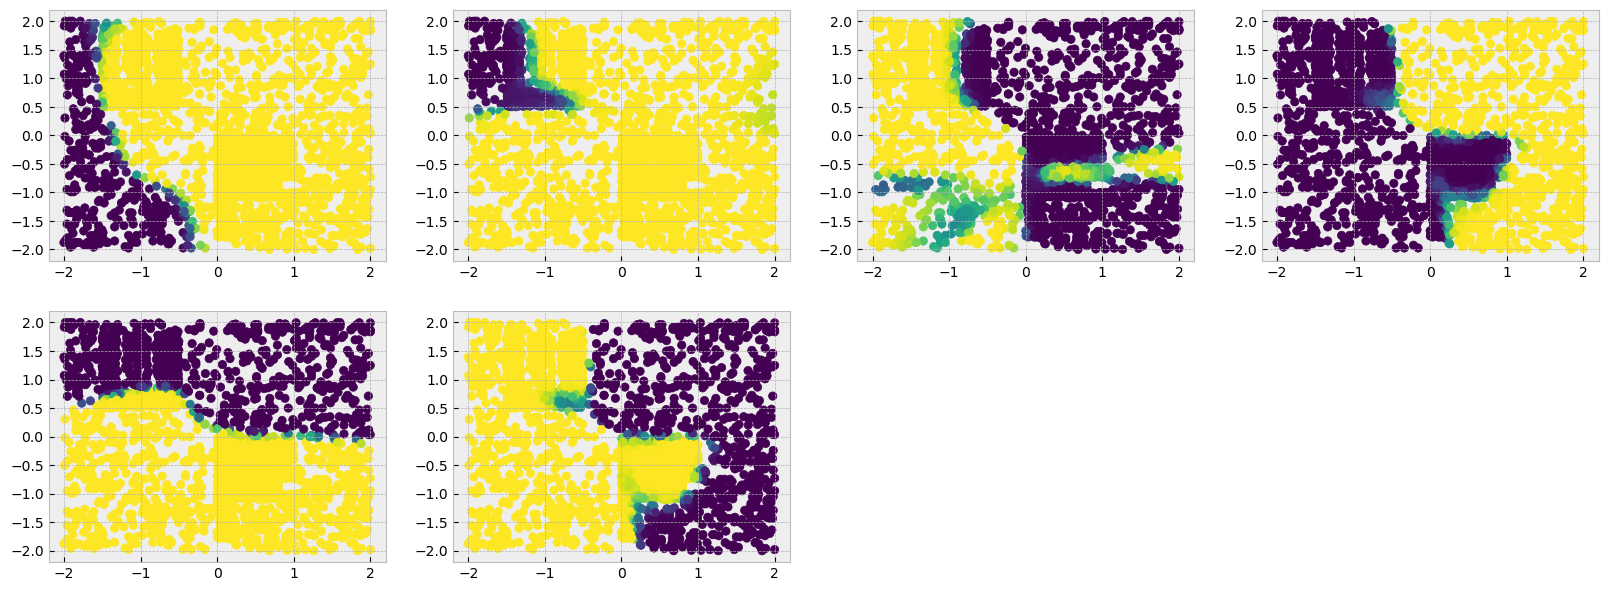

In [14]:
plt.figure(figsize=(20,15))
for i in range(h2.shape[1]):
    plt.subplot(4,4,i+1)
    plt.scatter(X[:,0], X[:,1], c=h2[:,i]);

In [15]:
o = tanh(h2@net.coefs_[2] + net.intercepts_[2])

o.shape

(3000, 1)

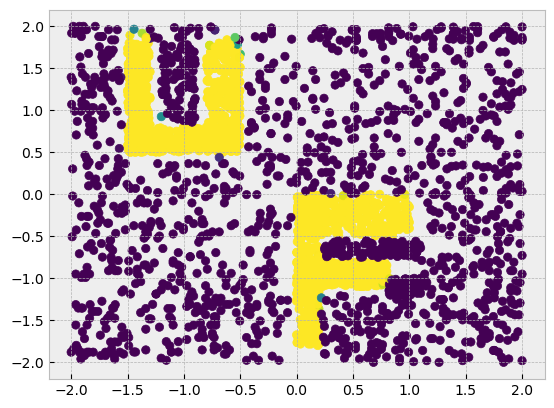

In [16]:
plt.scatter(X[:,0], X[:,1], c=o);

---

# Decision Maps in MLPs

[A Neural Network Playground](https://playground.tensorflow.org/#activation=tanh&regularization=L2&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.1&regularizationRate=0&noise=10&networkShape=2&seed=0.66302&showTestData=false&discretize=false&percTrainData=80&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) is a great tool to provide visual interpretation of MLPs performance. You can choose and interpret the effect of the use of different features, architecture size, learning rate, among others.

---

# Challenges in Training ANNs

We have introduced standard MLPs, which are generally shallow networks, with just a few layers. What if you need to tackle a very complex problem, such as detecting hundreds of types of objects in high-resolution images? You may need to train a much deeper architecture, perhaps with 10 layers or much more, each containing hundreds of neurons, connected by hundreds of thousands of connections. This would not be an easy task.

1. **Vanishing gradient problem**. You would be faced with the tricky vanishing gradients problem (or the related exploding gradients problem) that affects deep neural networks and makes lower layers very hard to train. 

2. **Not enough training data**. You might not have enough training data for such a large network, or it might be too costly to label. 

3. **Training is too slow**. Training may be extremely slow. 

4. **Model has millions of parameters causing a severe risk of overfitting**. A model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances, or they are too noisy.

___